In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import netcdf
from scipy import signal

In [2]:
depths = ['surface', '500m', '1500m']
fpaths = ['/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik1_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik58_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik89_Rb_0p8_Rmin_2dx/']
grids = ['GLazur64-T20_y2009m0607_gridU_ik1.nc',
        'GLazur64-T20_y2009m0607_gridV_ik1.nc',
        'GLazur64-T20_y2009m0607_gridU_ik58.nc',
        'GLazur64-T20_y2009m0607_gridV_ik58.nc',
        'GLazur64-T20_y2009m0607_gridU_ik89.nc',
        'GLazur64-T20_y2009m0607_gridV_ik89.nc']
gridU = {depth:[] for depth in depths}  # zonal velocities at each depth
gridV = {depth:[] for depth in depths}  # meridional velocities at each depth
j = 0
for i,depth in enumerate(depths):
    gridU[depth] = netcdf.netcdf_file(fpaths[i] + grids[j],'r')
    gridV[depth] = netcdf.netcdf_file(fpaths[i] + grids[j+1],'r')
    j += 2

In [3]:
lon_lo = gridU['surface'].variables['nav_lon'][0, 0].copy()    # lowest longitude
lon_hi = gridU['surface'].variables['nav_lon'][-1, -1].copy()  # highest longitude
lat_lo = gridU['surface'].variables['nav_lat'][0, 0].copy()    # lowest latitude
lat_hi = gridU['surface'].variables['nav_lat'][-1, -1].copy()  # highest longitude
nav_res = 1./64  # spatial resolution (degrees)

"""find indices of (5.5, 42.5) and (6.5, 43) - bottom left of areas"""
target_lons = [5.5, 6.5]
target_lats = [42.5, 43]
i_lons = [int((target_lon - lon_lo)/nav_res) for target_lon in target_lons]
i_lats = [int((target_lat - lat_lo)/nav_res) for target_lat in target_lats]
i_lon_hi = len(gridU['surface'].variables['nav_lon'][0,:])-1
print('i_lons:', i_lons)
print('i_lats:', i_lats)
print('index of last lon:', i_lon_hi)

i_lons: [217, 281]
i_lats: [79, 111]
index of last lon: 376


In [4]:
# import file
fpath_temp = '/gscratch/jisao/mclaret/GL64/Juin_Novembre/'
gridT_k1 = netcdf.netcdf_file(fpath_temp + 'GLazur64-T20_y2009m06_m11_gridT_k1.nc','r')

# keep variables
map_lats = gridT_k1.variables['nav_lat'][:][:].copy()
map_lons = gridT_k1.variables['nav_lon'][:][:].copy()
land = gridT_k1.variables['votemper'][0][0][:][:].copy()
water = gridT_k1.variables['votemper'][0][0][:][:].copy()
gridT_k1.close()

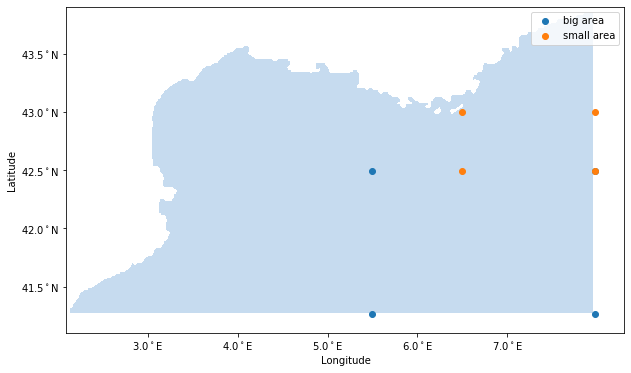

In [5]:
# visually check indices
fig, ax = plt.subplots(figsize=(10,6))
land = np.ma.masked_where(land == 0.0, land)
water = np.logical_not(land)

# plot map
plt.contourf(map_lons, map_lats, water,cmap='Blues')

# format lat/long labels
locs, labels = plt.xticks()
Elabels = [str(loc) + '$^\circ$E' for loc in locs]
plt.xticks(locs[1:-1], Elabels[1:-1])
locs, labels = plt.yticks()
Nlabels = [str(loc) + '$^\circ$N' for loc in locs]
plt.yticks(locs[1:-1], Nlabels[1:-1])

sizes = ['small', 'big']
lonRanges = {size:[] for size in sizes}
latRanges = {size:[] for size in sizes}
lonRanges['small'] = np.arange(i_lons[0], i_lon_hi, 1)
latRanges['small'] = np.arange(0, i_lats[0],1)
lonRanges['big'] = np.arange(i_lons[1], i_lon_hi,1)
latRanges['big'] = np.arange(i_lats[0], i_lats[1],1)

# plot dots
xs = [gridU['surface'].variables['nav_lon'][0,i_lons[0]].copy(),
      gridU['surface'].variables['nav_lon'][0,i_lons[0]].copy(),
      gridU['surface'].variables['nav_lon'][0,i_lon_hi].copy(),
      gridU['surface'].variables['nav_lon'][0,i_lon_hi].copy()]
ys = [gridU['surface'].variables['nav_lat'][0,0].copy(),
      gridU['surface'].variables['nav_lat'][i_lats[0],0].copy(),
      gridU['surface'].variables['nav_lat'][i_lats[0],0].copy(),
      gridU['surface'].variables['nav_lat'][0,0].copy()]
plt.scatter(xs, ys, label='big area')
xs = [gridU['surface'].variables['nav_lon'][0,i_lons[1]].copy(),
      gridU['surface'].variables['nav_lon'][0,i_lons[1]].copy(),
      gridU['surface'].variables['nav_lon'][0,i_lon_hi].copy(),
      gridU['surface'].variables['nav_lon'][0,i_lon_hi].copy()]
ys = [gridU['surface'].variables['nav_lat'][i_lats[0],0].copy(),
      gridU['surface'].variables['nav_lat'][i_lats[1],0].copy(),
      gridU['surface'].variables['nav_lat'][i_lats[1],0].copy(),
      gridU['surface'].variables['nav_lat'][i_lats[0],0].copy()]
plt.scatter(xs, ys, label='small area')

# figure labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [6]:
# parameters for fft
omega = 7.2921e-5
maxt = len(gridU['surface'].variables['vozocrtx'][:, 0, 0, 0].copy())  # num times
dt = 1.0                      # temporal resolution  (hrs)
T = (maxt)*dt                 # final time
times = np.arange(1,T+1,dt)
print('maxt = ', maxt)
print('T =', T)
print('times = ', times)

fCor = {size:[] for size in sizes}
for size in sizes:
    # find coriolis frequency using center of each area
    i = latRanges[size][len(latRanges[size])%2]
    fCor[size] = 2.*omega*np.sin((gridU['surface'].variables['nav_lat'][i,0].copy())/180*np.pi)  # f of area; radians/sec

maxt =  768
T = 768.0
times =  [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182.
 183. 184. 185. 186. 187. 188. 189. 190. 191. 

In [7]:
plotVars = ['amps', 'freqs']              # plot variables
spectra = {depth:[] for depth in depths}  # spectra for each depth

for depth in depths:
    spectra[depth] = {plotVar:[] for plotVar in plotVars}  # plot variables for each depth
    amp = [0. for time in times]  # amplitudes
    fq = [0. for time in times]   # frequencies corresponding to each FC (cycles/h)   # frequencies
    for size in sizes:
        N = 0  # num ffts
        amp_temp = np.array([0. for time in times])
        fq_temp = 0
        for lon in lonRanges[size]:
            for lat in latRanges[size]:
                U = gridU[depth].variables['vozocrtx'][:, 0, lat, lon].copy()  # zonal velocities
                V = gridV[depth].variables['vomecrty'][:, 0, lat, lon].copy()  # meridional velocities
                
                win = signal.tukey(len(U), 0.2)  # Tukey window (20%)
                
                hvel = U + 1j*V             # combine U and V
                fcs = np.fft.fft(hvel*win)  # Fourier coefficients (FCs) w/ window
                amp_temp += np.abs(fcs)**2
                N += 1
        fq_temp += np.fft.fftfreq(times.shape[-1],dt)*2*np.pi/fCor[size]/3600
        amp += amp_temp/N
        fq += fq_temp
    spectra[depth]['amps'] = np.fft.fftshift(amp/len(sizes))
    spectra[depth]['freqs'] = np.fft.fftshift(fq/len(sizes))

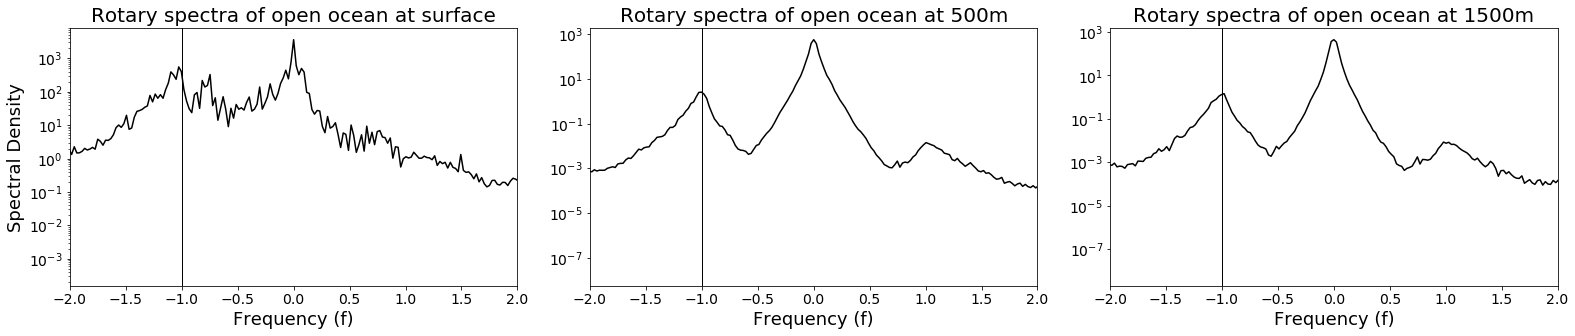

In [15]:
fig = plt.figure(figsize=(22.1,4.77))
i=1
for depth in depths:
    # plot rotary spectra
    ax = fig.add_subplot(1,3,i)
    ax.plot(spectra[depth]['freqs'], spectra[depth]['amps'], color='k')
    ax.set_xlim(-2,2)
    
    # Set the font name for axis tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
            
    # plot labels
    ax.set_yscale('log')
    plt.axvline(x=-1, color='k', linewidth=1)
    ax.set_xlabel('Frequency (f)', fontsize=18)
    ax.set_title('Rotary spectra of open ocean at '+depth, fontsize=20)
    if i<2:
        ax.set_ylabel('Spectral Density', fontsize=18)
    i+=1

fig_path = './figures/'
fname = 'spectra_area.png'
fig.tight_layout()
fig.savefig(fig_path+fname, dpi=80)